In [4]:
import JupyterNotebooksLib as slicernb

In [5]:
this_notebook_name = "SpineSegmentationVisualTest"

# place path to scene to test here
scene_to_segment = r"d:\Data\VerdureSegmentations\AiDone\388_Ax_AiSegDone.mrb"

# set this to the name of the model to study
# model_path = r"C:\Users\perkl\Documents\AIGT\aigt\SavedModels\SavedModels\SagittalSpineSegmentationStudy-TF2_model-0_2020-05-11_16-30-08.h5"

In [6]:
slicer.mrmlScene.Clear()
try:
    slicer.util.loadScene(scene_to_segment)
except:
    # NOTE: for some reason loading a scene throws an error every time, but laods the scene just fine
    print('Error thrown. Continuing.')
    

Error thrown. Continuing.


In [15]:
# Find input volume (image) for volume reconstruction

predictionVolume = slicer.mrmlScene.GetFirstNodeByName("PredictionImage")
if predictionVolume is None:
    raise Exception("PredictionImage not found in Slicer scene")

In [16]:
# Create output volume node

reconstructedVolume = slicer.mrmlScene.GetFirstNodeByName("AiVolume")
if reconstructedVolume is None:
    reconstructedVolume = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode")
    reconstructedVolume.SetName("AiVolume")

In [17]:
inputBrowserNode = slicer.mrmlScene.GetFirstNodeByName("BonePredictionBrowser")
if inputBrowserNode is None:
    raise Exception("BonePredictionBrowser missing")

In [18]:
# Prepare volume reconstructor node

volumeReconstructor = slicer.mrmlScene.GetFirstNodeByName("AiVolumeReconstructor")
if volumeReconstructor is None:
    volumeReconstructor = slicer.vtkMRMLVolumeReconstructionNode()
    volumeReconstructor.SetName("AiVolumeReconstructor")
    volumeReconstructor.SetLiveVolumeReconstruction(False)
    volumeReconstructor.SetOptimizationMode(slicer.vtkMRMLVolumeReconstructionNode.FULL_OPTIMIZATION)
    volumeReconstructor.SetCompoundingMode(slicer.vtkMRMLVolumeReconstructionNode.MAXIMUM_COMPOUNDING_MODE)
    volumeReconstructor.SetInterpolationMode(slicer.vtkMRMLVolumeReconstructionNode.LINEAR_INTERPOLATION)
    slicer.mrmlScene.AddNode(volumeReconstructor)

volumeReconstructor.SetAndObserveInputSequenceBrowserNode(inputBrowserNode)
volumeReconstructor.SetAndObserveOutputVolumeNode(reconstructedVolume)
volumeReconstructor.SetAndObserveInputVolumeNode(predictionVolume)

volumeReconstructionLogic = slicer.modules.volumereconstruction.logic()

In [19]:
# Volume reconstruction

volumeReconstructionLogic.ReconstructVolumeFromSequence(volumeReconstructor)


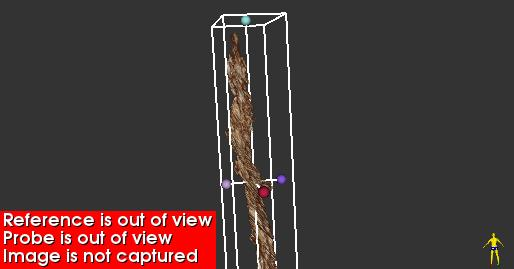

In [20]:
slicernb.display3DView()